### Time Series with ARIMA

Build a model to forecast the demand(passenger traffic) in Airplanes. The data is classified in date/time and the passengers travelling per month



What is Time series analysis - 

A. Time Series is a series of observations taken at specified time intervals usually equal intervals. Analysis of the series helps us to predict future values based on previous observed values. In Time series, we have only 2 variables, time & the variable we want to forecast.



In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
'''
adfuller. Augmented Dickey-Fuller unit root test. The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process 
in the presence of serial correlation.

'''
from statsmodels.tsa.stattools import acf, pacf
'''
acf. Calculate the autocorrelation function. If True, returns the Ljung-Box q statistic for each autocorrelation coefficient.

If a number is given, the confidence intervals for the given level are returned. ... 05, 95 % confidence intervals are returned where the standard deviation is computed according to 1/sqrt(len(x)). 
Returns pacf ndarray. Partial autocorrelations, nlags elements, including lag zero.

'''
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
'''
Each time Matplotlib loads, it defines a runtime configuration (rc) containing the default styles for every plot element you create. 
This configuration can be adjusted at any time using the plt. 
matplotlibrc file, which you can read about in the Matplotlib documentation.

'''
rcParams['figure.figsize'] = 10, 6


In [ ]:
data = pd.read_csv('../input/air-passengers/AirPassengers.csv')
data.head()

In [ ]:
data.dtypes

In [ ]:

# parse strings 
data['Month'] = pd.to_datetime(data['Month'], infer_datetime_format=True)


In [ ]:
data.dtypes

In [ ]:
indexedData = data.set_index(['Month'])
indexedData.head()

From the plot below, we can see that there is a Trend compoenent in th series. Hence, we now check for stationarity of the data



In [ ]:
# plot graph
plt.xlabel('Date')
plt.ylabel('Number of air passengers')
plt.plot(indexedData)

In [ ]:
# Datermine rolling statistics 
rolmean = indexedData.rolling(window=12).mean() # window size 12 denotes 12 months, giving rolling mean at yearly level
# rolmean.head()
rolstd = indexedData.rolling(window=12).std()


In [ ]:
print(rolmean,rolstd)


In [ ]:
# plot rolling statistics
orig = plt.plot(indexedData, color='g', label='Original')
mean = plt.plot(rolmean, color='r', label='Rolling Mean')
std = plt.plot(rolstd, color='b', label='Rolling Std')
plt.legend(loc='best')
plt.title("Rolling Mean & Standard Deviation")
plt.show(block=False)

From the above graph, we see that rolling mean itself has a trend component even though rolling standard deviation is fairly constant with time. For our time series to be stationary, we need to ensure that both the rolling statistics ie: mean & std. dev. remain time invariant or constant with time. Thus the curves for both of them have to be parallel to the x-axis, which in our case is not so.

To further augment our hypothesis that the time series is not stationary, let us perform the ADCF test.



In [ ]:
# perform augmented dickey-fuller test
print("Results of Dickey Fuller Test:")
dftest = adfuller(indexedData["#Passengers"], autolag='AIC')
'''
autolag{“AIC”, “BIC”, “t-stat”, None } Method to use when automatically determining the lag length among the values 0, 1,
maxlag. If “AIC” (default) or “BIC”, then the number of lags is chosen to minimize the corresponding information criterion

'''
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

For a Time series to be stationary, its ADCF test should have:

* p-value to be low (according to the null hypothesis)
* The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

From the above ADCF test result, we see that p-value(at max can be 1.0) is very large. Also critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

Data Transformation to achieve Stationarity 
There are a couple of ways to achieve stationarity through data transformation like taking  log10 , loge , square, square root, cube, cube root, exponential decay, time shift and so on ...

In our notebook, lets start of with log transformations. Our objective is to remove the trend component. Hence, flatter curves( ie: paralle to x-axis) for time series and rolling mean after taking log would say that our data transformation did a good job.



In [ ]:
# estimating trend
indexedData_logscale = np.log(indexedData)
plt.plot(indexedData_logscale)

In [ ]:
# the below transformation is required to make series stationary
movingAverage = indexedData_logscale.rolling(window=12).mean()
movingSTD = indexedData_logscale.rolling(window=12).std()
plt.plot(indexedData_logscale)
plt.plot(movingAverage, color='r')
plt.title("movingAverage & movingSTD")

plt.show()

From above graph, we see that even though rolling mean is not stationary, it is still better than the previous case, where no transfromation were applied to series. So we can atleast say that we are heading in the right direction.

We know from above graph that both the Time series with log scale as well as its moving average have a trend component. Thus we can apply a elementary intuition: subtraction one from the other should remove the trend component of both. Its like:

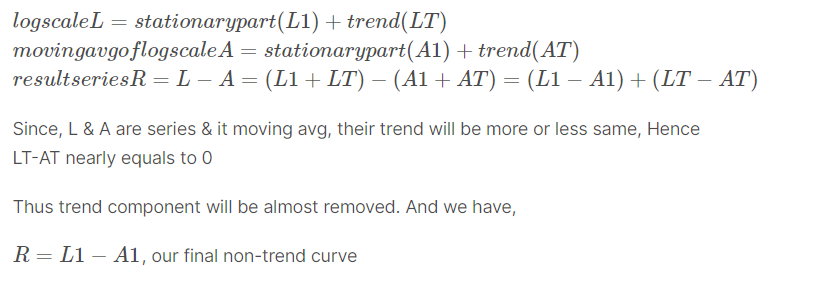

In [ ]:
datasetLogScaleMinusMovingAverage = indexedData_logscale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)


In [ ]:
# Remove Nan values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

In [ ]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='g', label='Original')
    mean = plt.plot(movingAverage, color='r', label='Rolling Mean')
    std = plt.plot(movingSTD, color='b', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['#Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

From above graph, we observe that our intuition that "subtracting two related series having similar trend components will make the result stationary" is true. We find that:

* p-value has reduced from 0.99 to 0.022.
* The critical values at 1%,5%,10% confidence intervals are pretty close to the Test Statistic. Thus, from above 2 points, we can say that our given series is stationary.

But, in the spirit of getting higher accuracy, let us explore & try to find a better scale than our current log.

Let us try out Exponential decay.
For further info, refer to my answer 12 at the top of the notebook on it.



### Exponential Decay Transformation

In [ ]:
exponentialDecayWeightedAverage = indexedData_logscale.ewm(halflife=12, min_periods=0, adjust=True).mean()
'''
The ewm() function is used to provide exponential weighted functions. Specify decay in terms of center of mass, α=1/(1+com), 
for com≥0. Specify decay in terms of span, α=2/(span+1), for span≥1. Specify decay in terms of half-life, α=1−exp(log(0.5)/halflife),forhalflife>0.
'''
plt.plot(indexedData_logscale)
plt.plot(exponentialDecayWeightedAverage,color='g')
plt.show()

From above graph, it seems that exponential decay is not holding any advantage over log scale as both the corresponding curves are similar. But, in statistics, inferences cannot be drawn simply by looking at the curves. Hence, we perform the ADCF test again on the decay series below.



In [ ]:
datasetLogScaleMinusExponentialMovingAverage = indexedData_logscale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)


We observe that the Time Series is stationary & also the series for moving avg & std. dev. is almost parallel to x-axis thus they also have no trend.
Also,

p-value has decreased from 0.022 to 0.005.
Test Statistic value is very much closer to the Critical values.
Both the points say that our current transformation is better than the previous logarithmic transformation. Even though, we couldn't observe any differences by visually looking at the graphs, the tests confirmed decay to be much better.
But lets try one more time & find if an even better solution exists. We will try out the simple time shift technique, which is simply:

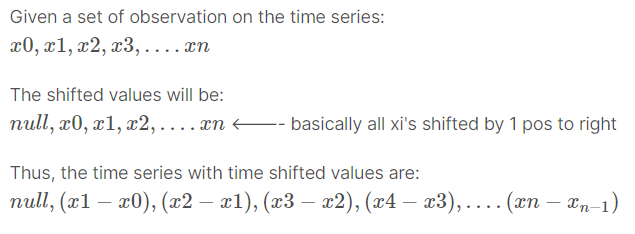



### Time Shift Transformation

In [ ]:
datasetLogDiffShifting = indexedData_logscale - indexedData_logscale.shift()
plt.plot(datasetLogDiffShifting,color='orange')
plt.show()

In [ ]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)


From above 2 graphs, we can see that, visually this is the best result as our series along with rolling statistic values of moving avg & moving std. dev. is very much flat & stationary. But, the ADCF test shows us that:

* p-value of 0.07 is not as good as 0.005 of exponential decay.
* Test Statistic value not as close to the critical values as that for exponential decay.

We have thus tried out 3 different transformation: log, exp decay & time shift. For simplicity, we will go with the log scale. The reason for doing this is that we can revert back to the original scale during forecasting.

Let us now break down the 3 components of the log scale series using a system libary function. Once, we separate our the components, we can simply ignore trend & seasonality and check on the nature of the residual part.



In [ ]:
decomposition = seasonal_decompose(indexedData_logscale) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot()
plt.plot(indexedData_logscale, label='Original')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.subplot()
plt.plot(trend, label='Trend',color='red')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.subplot()
plt.plot(seasonal, label='Seasonality',color='orange')
plt.legend(loc='best')
plt.show()

In [ ]:
plt.subplot()
plt.plot(residual, label='Residuals',color='brown')
plt.legend(loc='best')
plt.show()

In [ ]:
'''
there can be cases where an observation simply consisted of trend and seasonality. in that case, there won't be
any residual component and would be a null or Nan. heance, we also remove such cases

'''
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
# test_stationarity(decomposedLogData)

In [ ]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

# plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='red')
# axhline() Function. The axhline() function in pyplot module of matplotlib library is used to add a horizontal line across the axis.
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')  

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='red')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
            
plt.tight_layout()            

From the ACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, Q = 2
From the PACF graph, we see that curve touches y=0.0 line at x=2. Thus, from theory, P = 2

ARIMA is AR + I + MA. Before, we see an ARIMA model, let us check the results of the individual AR & MA model. Note that, these models will give a value of RSS. Lower RSS values indicate a better model.

### Building Models

In [ ]:
'''
In fact, the AR and MA components are identical, combining a general autoregressive model AR(p) and general moving average model MA(q). 
AR(p) makes predictions using previous values of the dependent variable. 
MA(q) makes predictions using the series mean and previous errors.


Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, 
p is the order (number of time lags) of the autoregressive model, 
d is the degree of differencing (the number of times the data have had past values subtracted), and 
q is the order of the moving-average

disp = If True, convergence information is printed. For the default l_bfgs_b solver, disp controls the frequency of the output during the iterations. 
disp < 0 means no output in this case.


'''
#AR Model
#making order=(2,1,0) gives RSS=1.5023
model = ARIMA(indexedData_logscale, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='Gold')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting AR model')

In [ ]:
#MA Model
model = ARIMA(indexedData_logscale, order=(0,1,2))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting,color='orange')
plt.plot(results_MA.fittedvalues, color='green')
plt.title('RSS: %.4f'%sum((results_MA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting MA model')

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(indexedData_logscale, order=(2,1,2))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting,color='blue')
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_ARIMA.fittedvalues - datasetLogDiffShifting['#Passengers'])**2))
print('Plotting ARIMA model')

By combining AR & MA into ARIMA, we see that RSS value has decreased from either case to 1.0292, indicating ARIMA to be better than its individual component models.   

With the ARIMA model built, we will now generate predictions. But, before we do any plots for predictions ,we need to reconvert the predictions back to original form. This is because, our model was built on log transformed data.

### Prediction & Reverse Transformations

In [ ]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy = True)
predictions_ARIMA_diff.head()

In [ ]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

In [ ]:
predictions_ARIMA_log = pd.Series(indexedData_logscale['#Passengers'].iloc[0], index=indexedData_logscale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

In [ ]:
# Inverse of log is exp
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedData)
plt.plot(predictions_ARIMA)
plt.show()

We see that our predicted forecasts are very close to the real time series values indicating a fairly accurate model.

In [ ]:
#We have 144(existing data of 12 yrs in months) data points. 
#And we want to forecast for additional 120 data points or 10 yrs.
# results_ARIMA.plot_predict(1,264) 
#x=results_ARIMA.forecast(steps=120)
results_ARIMA.plot_predict(1,264) 
